<a href="https://colab.research.google.com/github/jonaden94/deepl-ecker-21-22/blob/main/Data_Set_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb Data Set Introduction

This simple introduction to the Airbnb data set(s) will give you a short overview over the available data. The city used for this introduction is Berlin, hence if you want to run the exact same notebook for a different city you would need to change a few minor details. Otherwise, if you have downloaded all necessary data sets and run this notebook in the same directory it should run smoothly.

### Index
1. Load data set
2. Price analysis
    * (Inspect reviews)
3. Main file (listings.csv.gz)
4. "Analyze" Images
5. "Analyze" Reviews
6. Calendar file
7.  neighbourhoods Geo.json file

In [4]:
%%capture
!wget http://data.insideairbnb.com/austria/vienna/vienna/2021-11-07/data/listings.csv.gz
!wget http://data.insideairbnb.com/austria/vienna/vienna/2021-11-07/data/calendar.csv.gz
!wget http://data.insideairbnb.com/austria/vienna/vienna/2021-11-07/data/reviews.csv.gz
!wget http://data.insideairbnb.com/austria/vienna/vienna/2021-11-07/visualisations/listings.csv
!wget http://data.insideairbnb.com/austria/vienna/vienna/2021-11-07/visualisations/reviews.csv
!wget http://data.insideairbnb.com/austria/vienna/vienna/2021-11-07/visualisations/neighbourhoods.csv
!wget http://data.insideairbnb.com/austria/vienna/vienna/2021-11-07/visualisations/neighbourhoods.geojson

In [5]:
%%capture
!pip install transformers
!pip install geopandas
import pandas as pd
import numpy as np
import gzip
from PIL import Image
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
import requests
from io import BytesIO
import matplotlib.image as mpimg

from shapely.geometry import Point, Polygon

import seaborn as sns

from transformers import pipeline

import folium
from folium.plugins import FastMarkerCluster
from branca.colormap import LinearColormap

# 1. Load the Data

All availabe data sets are listed on: http://insideairbnb.com/get-the-data.html

For all cities there are 7 files:\
listings.csv \
reviews.csv \
listings.csv.gz \
reviews.csv.gz \
calendar.csv.gz \
neighbourhoods.geojson \
neighbourhoods.csv 

In [7]:
listings = pd.read_csv("listings.csv")
reviews = pd.read_csv("reviews.csv")

In [8]:
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,15883,b&b near Old Danube river,62142,Eva,NaN,Donaustadt,48.24262,16.42767,Hotel room,120,1,14,2019-07-17,0.29,3,364,3,NaN
1,38768,central cityapartement- wifi- nice neighbourhood,166283,Hannes,NaN,Leopoldstadt,48.21924,16.37831,Entire home/apt,61,3,334,2021-09-05,2.92,3,140,11,NaN
2,40625,"Near Palace Schönbrunn, Apt. 1",175131,Ingela,NaN,Rudolfsheim-Fnfhaus,48.18434,16.32701,Entire home/apt,131,1,162,2019-11-24,1.85,15,275,7,NaN
3,51287,little studio- next to citycenter- wifi- nice ...,166283,Hannes,NaN,Leopoldstadt,48.21778,16.37847,Entire home/apt,59,3,324,2021-11-04,2.78,3,142,15,NaN
4,70637,Flat in the Center with Terrace,358842,Elxe,NaN,Leopoldstadt,48.21760,16.38018,Private room,50,2,117,2019-12-17,0.95,3,302,1,NaN


# 2. Simple price analysis

Text(0.5, 1.0, 'number_of_reviews_ltm')

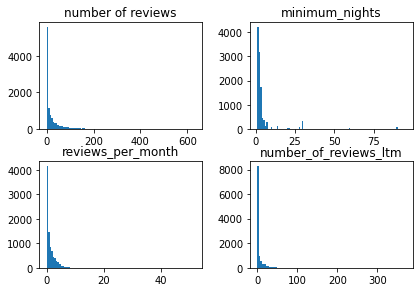

In [75]:
#@title descriptive analysis of individual variables

x = [1,2,3,4]
y = [2,2,3,4]
fig, axs = plt.subplots(2, 2)
fig.tight_layout()
axs[0, 0].hist(listings["number_of_reviews"], bins=100);
axs[0, 0].set_title('number of reviews')
axs[0, 1].hist(listings["minimum_nights"][listings["minimum_nights"]<100], bins=100);
axs[0, 1].set_title('minimum_nights')
axs[1, 0].hist(listings["reviews_per_month"], bins=100);
axs[1, 0].set_title("reviews_per_month")
axs[1, 1].hist(listings["number_of_reviews_ltm"], bins=100);
axs[1, 1].set_title('number_of_reviews_ltm')


To get a short overview over the prices and neighbourhoods lets group the data by their neighbourhood group and look at the prices. For Berlin the highest prices seem to be in the district of Charlottenburg. 

Be aware that some cities do not have neighbourhood groups. You can simply switch the grouping to a desired column name or the respecivte name of the column where the districts/neighbourhood groups are stored in.

In [ ]:
# lets first drop all 0 prices as they are probably faulty
listings = listings[listings["price"] != 0]

In [ ]:
listings[["price", "neighbourhood", "number_of_reviews"]].groupby(
    ["neighbourhood"]
).mean().round(1).sort_values(by="price", ascending=False)

,price,number_of_reviews
neighbourhood,,
Innere Stadt,157.4,43.4
Hietzing,148.4,24.7
Neubau,101.4,44.2
Mariahilf,85.5,36.4
Wieden,85.5,45.8
Josefstadt,84.1,29.7
Donaustadt,82.7,17.3
Alsergrund,81.1,28.3
Floridsdorf,79.8,12.4


you might expect large price differences between the offered room types. For example, a private room is usually more expensive than a shared room.

In [ ]:
listings[["price", "room_type", "number_of_reviews"]].groupby(
    ["room_type"]
).mean().round(1).sort_values(by="price", ascending=False)

,price,number_of_reviews
room_type,,
Hotel room,290.3,36.7
Entire home/apt,87.1,35.9
Private room,53.9,19.0
Shared room,37.4,14.9


### Inspect dependent variable: Price

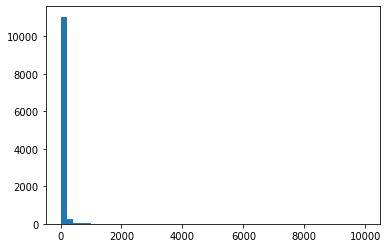

In [ ]:
plt.hist(listings["price"], bins=50)
plt.show()

### Remove "extreme" Prices above 500 €

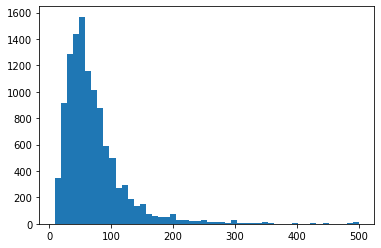

In [ ]:
plt.hist(listings[listings["price"] <= 500]["price"], bins=50)
plt.show()

### Take logarithm

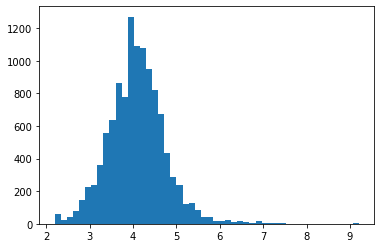

In [ ]:
plt.hist(np.log(listings["price"]), bins=50)
plt.show()

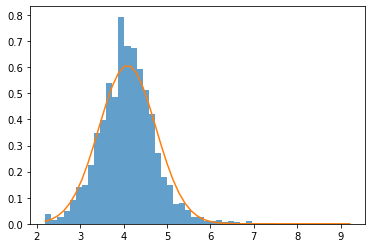

In [ ]:
import scipy

_, bins, _ = plt.hist(np.log(listings["price"]), 50, density=1, alpha=0.7)
mu, sigma = scipy.stats.norm.fit(np.log(listings["price"]))
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

# 2.1 Inspect reviews.csv 
Only includes the date of a review -> There might be some valuable information stored in these dates, however we will not take a closer look at these in this notebook, as this are merely dates for the giving listings.

In [ ]:
reviews.head()

,listing_id,date
0,15883,2015-04-10
1,15883,2016-06-19
2,15883,2016-07-29
3,15883,2016-08-13
4,15883,2016-11-21


# 3. listings.csv.gz -> Main file
They can also be loaded with pd.read_csv

In [ ]:
listings_meta = pd.read_csv("listings.csv.gz")
reviews_meta = pd.read_csv("reviews.csv.gz")
calendar = pd.read_csv("calendar.csv.gz")

## Inspect listings.csv.gz 
This is the larger listings-file with 74 columns and 19858 observations

In [ ]:
listings_meta.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,15883,https://www.airbnb.com/rooms/15883,20211107161644,2021-11-08,b&b near Old Danube river,"Four rooms, each one differently and individua...",small and personal<br /><br />Four rooms at th...,https://a0.muscache.com/pictures/18eff738-a737...,62142,https://www.airbnb.com/users/show/62142,Eva,2009-12-11,"Vienna, Wien, Austria",Mein größtes Hobby: Reisen! Am liebsten mit me...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/24166...,https://a0.muscache.com/im/pictures/user/24166...,Donaustadt,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Vienna, Austria",Donaustadt,NaN,48.24262,16.42767,Room in bed and breakfast,Hotel room,3,NaN,1 private bath,1.0,2.0,"[""Essentials"", ""Smoke alarm"", ""Free street par...",$120.00,1,365,1,1,365,365,1.0,365.0,NaN,t,29,59,89,364,2021-11-08,14,3,0,2017-11-19,2019-07-17,4.71,4.86,4.93,4.93,4.86,4.71,4.50,NaN,f,3,1,0,0,0.29
1,38768,https://www.airbnb.com/rooms/38768,20211107161644,2021-11-08,central cityapartement- wifi- nice neighbourhood,39m² apartment with beautiful courtyard of the...,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,https://www.airbnb.com/users/show/166283,Hannes,2010-07-14,"Wien, Wien, Austria",I am open minded and like travelling myself. I...,NaN,NaN,NaN,t,https://a0.muscache.com/im/users/166283/profil...,https://a0.muscache.com/im/users/166283/profil...,Leopoldstadt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Vienna, Austria",Leopoldstadt,NaN,48.21924,16.37831,Entire rental unit,Entire home/apt,5,NaN,1 bath,1.0,3.0,"[""Shared patio or balcony"", ""Iron"", ""Portable ...",$61.00,3,100,3,3,1125,1125,3.0,1125.0,NaN,t,11,20,50,140,2021-11-08,334,11,2,2012-06-16,2021-09-05,4.75,4.80,4.66,4.91,4.93,4.74,4.70,NaN,t,3,3,0,0,2.92
2,40625,https://www.airbnb.com/rooms/40625,20211107161644,2021-11-08,"Near Palace Schönbrunn, Apt. 1",Welcome to my Apt. 1!<br /><br />This is a 2be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,https://www.airbnb.com/users/show/175131,Ingela,2010-07-20,"Vienna, Wien, Austria",I´m originally from Sweden but have been livin...,within a few hours,97%,81%,t,https://a0.muscache.com/im/users/175131/profil...,https://a0.muscache.com/im/users/175131/profil...,Rudolfsheim-Fünfhaus,16.0,16.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Vienna, Austria",Rudolfsheim-Fnfhaus,NaN,48.18434,16.32701,Entire rental unit,Entire home/apt,6,NaN,1 bath,2.0,4.0,"[""Wine glasses"", ""Clothing storage: wardrobe a...",$131.00,1,180,1,3,180,180,1.0,180.0,NaN,t,0,0,5,275,2021-11-08,162,7,2,2014-09-

In [ ]:
for column in listings_meta.columns:
    print(column)

id
listing_url
scrape_id
last_scraped
name
description
neighborhood_overview
picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
latitude
longitude
property_type
room_type
accommodates
bathrooms
bathrooms_text
bedrooms
beds
amenities
price
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
first_review
last_review
review_scores_rating
review_scores_accuracy
review_sc

You find a detailed overview over the meanings of all columns on https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896

### Adjust price column -> From string to float
In this file, unfortunately, the prices are not stored as integers/floats as in the previous file. Therefore we clean them up

In [ ]:
listings_meta["price"] = (
    listings_meta["price"].str.replace("$", "").str.replace(",", "").astype(float)
)

To compute an examplery correlation matrix we must encode the categorized variables we are using. In this caase the room type and the neighbourhood group

In [ ]:
# Encode the input Variables
def Encode(airbnb):
    for column in airbnb.columns[
        airbnb.columns.isin(["neighbourhood", "room_type"])
    ]:
        airbnb[column] = airbnb[column].factorize()[0]
    return airbnb


airbnb_en = Encode(listings_meta.copy())

## Compute correlation matrix

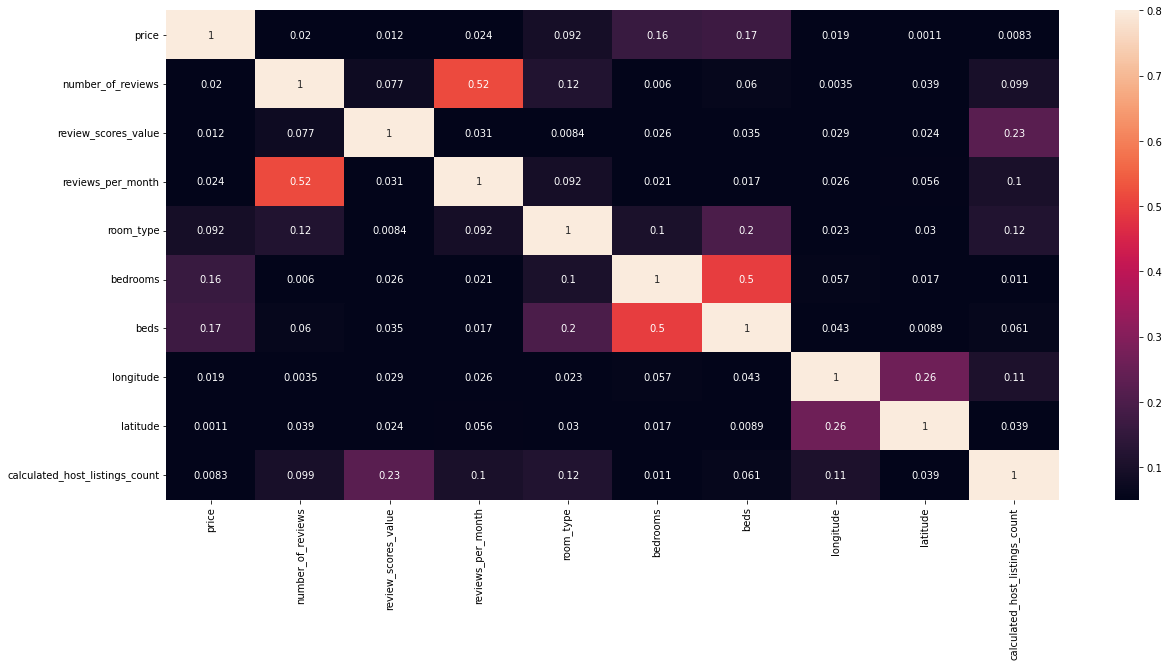

In [ ]:
corr_matrix = airbnb_en[
    [
        "price",
        "number_of_reviews",
        "review_scores_value",
        "reviews_per_month",
        "host_response_rate",
        "room_type",
        "bedrooms",
        "beds",
        "longitude",
        "latitude",
        "calculated_host_listings_count",
    ]
].corr()
corr_matrix = abs(corr_matrix)
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr_matrix, vmax=0.8, vmin=0.05, annot=True)

As expected, we are dealing with some correlation between some of the variables used. Be aware that the variables are used randomly and that there could be more meaningful and more variables that correlate with each other. Depending on your model choice, however, this is something you might want to have in mind.

## Analyze longitude and latitude
### Plot all the apartments offered in their location

#### This is specifically for the city of Berlin and you will not be able to run this cell because you do not have the necessary file saved locally. Since it is definitely not necessary for you all to have a .shp file of Berlin, I will not upload these files.
If you want to do this for another city, you will need to download a shp file of the city. 

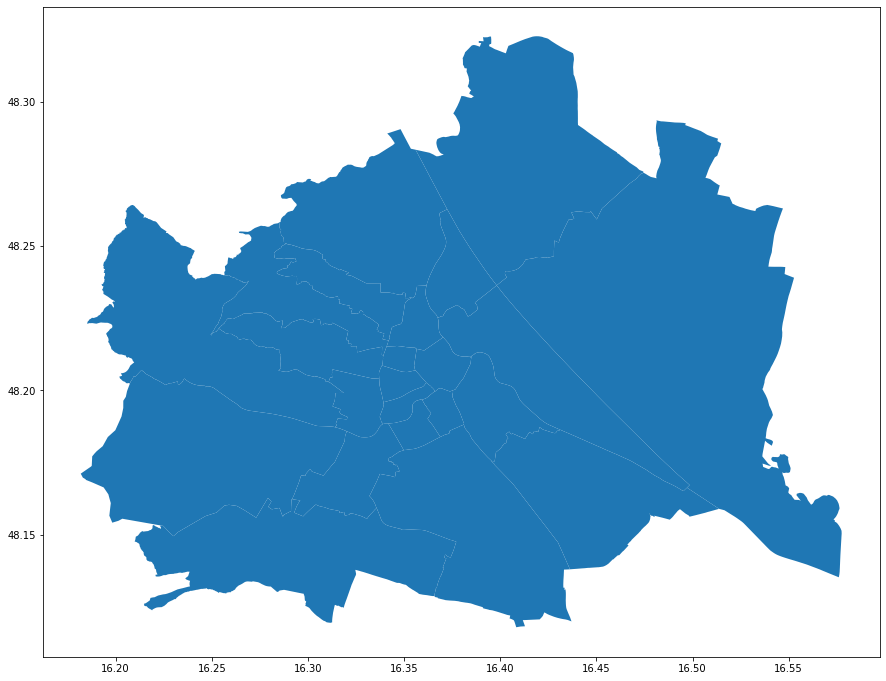

In [ ]:
street_map = gpd.read_file("/content/BEZIRKSGRENZEOGDPolygon.shp")
fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax)

In [ ]:
geometry = [
    Point(xy) for xy in zip(listings_meta["longitude"], listings_meta["latitude"])
]
geo_df = gpd.GeoDataFrame(listings_meta, crs={"init": "epsg:4326"}, geometry=geometry)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


No handles with labels found to put in legend.


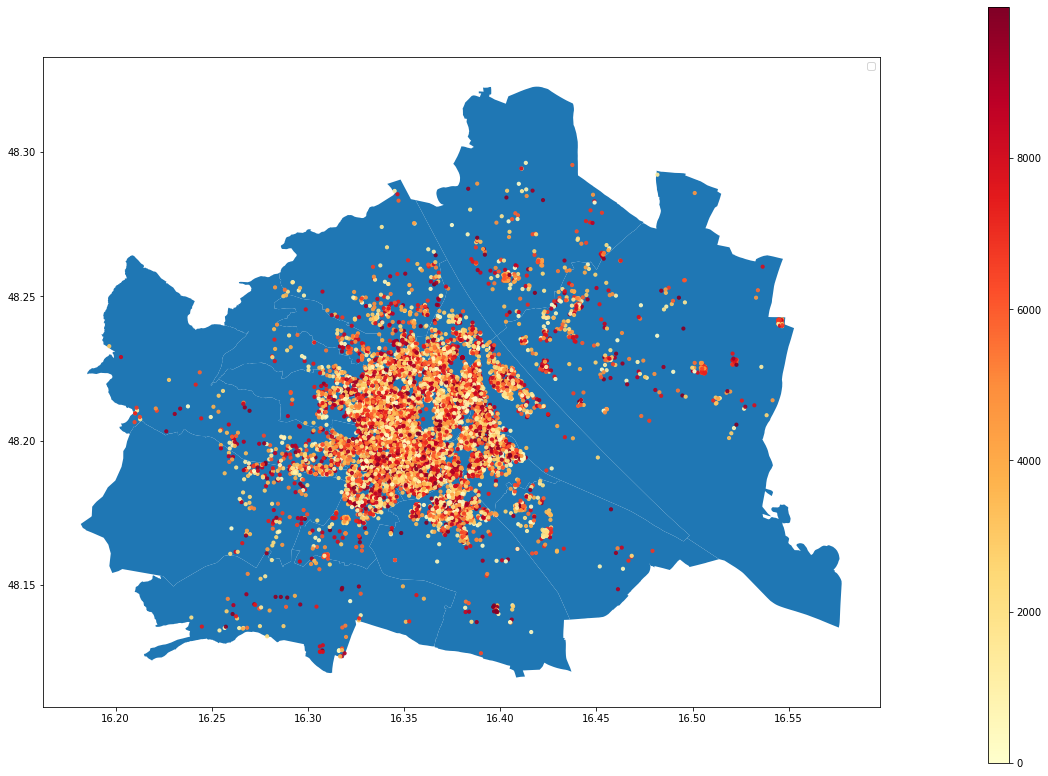

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
# ax.set_facecolor("black")
street_map.plot(ax=ax)
geo_df[geo_df["price"] > 0].plot(
    ax=ax,
    markersize=10,
    c=geo_df["price"],
    cmap=plt.get_cmap("YlOrRd"),
    alpha=0.9,
    zorder=5,
    legend=True,
)
plt.legend()
vmin = geo_df["price"].min()
vmax = geo_df["price"].max()
cax = fig.add_axes([1, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

cbr = fig.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=10)
plt.show()

## Grouped by their location and the amount of offerings in that area

There is no need to download a map, you just need to adjust the location, which is location=[52.520008, 13.404954] for Berlin 

In [ ]:
lats2018 = listings["latitude"].tolist()
lons2018 = listings["longitude"].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[48.25, 16.35], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

# Analyze a single entry

In [ ]:
listings_meta.loc[2][
    [
        "id",
        "host_name",
        "neighbourhood_cleansed",
        "room_type",
        "bedrooms",
        "beds",
        "amenities",
        "price",
        "review_scores_rating",
    ]
]

id                                                                    40625
host_name                                                            Ingela
neighbourhood_cleansed                                 Rudolfsheim-Fnfhaus
room_type                                                   Entire home/apt
bedrooms                                                                  2
beds                                                                      4
amenities                 ["Wine glasses", "Clothing storage: wardrobe a...
price                                                                   131
review_scores_rating                                                   4.84
Name: 2, dtype: object

In [ ]:
listings_meta.loc[3]["host_about"]

'I am open minded and like travelling myself. I have spent many months in Latinamerica and Asia, where I got  in touch with Indian philosophie and meditation...\r\nNow I mostly work in the field of contemporary art and I do my best to offer you a nice apartment next to the citycenter...!\r\n\r\n\r\n'

In [ ]:
listings_meta.loc[3]["description"]

'small studio in new renovated old house and very nice upcoming neighbourhood. close to many sights and subway. wifi. safe area, nice restaurants, bars and market. walking distance to citycenter. if wanted 2 old bicycles are available for free. touristtax of 3,2% is included in the price.<br /><br /><b>The space</b><br />Nice little studio in one of the oldest and beautiful houses of the neighbourhood, at the same time renovated house with new rooftops, free wifi. <br />Its a small and quiet apartment with a little balcony, 1st floor.<br />A modern sofa can be used as a double bed (1,60x2,05m). There is a well equipped little kitchencorner, a little bathroom with shower and toilett, extra heater and hair dryer. Fresh sheets and towels are provided. Of course there is hot water.<br />The spacious double bed (1,60mx2m) is located above the bathroom.  The ceiling of the shower is lower than usual. For low-budget guests I offer the option for up to 4 persons. the sleeping sofa is 1,40mx2m,

# 4. Analyze Images

## Load the image of the host.
### The link is stored in the column "host_picture_url"
#### Scraping is fairly simple, e.g. with "requests.get"

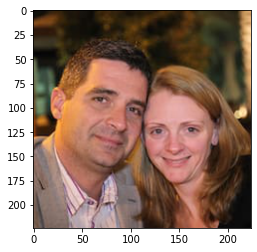

In [ ]:
IMAGE_SIZE = [224, 224]

response = requests.get(listings_meta.loc[200]["host_picture_url"])
img_plot = Image.open(BytesIO(response.content)).resize(IMAGE_SIZE)
plt.grid(False)
plt.imshow(img_plot)

## For each entry there is also a "picture_url" which is the thumbnail picture
### There are multiple images for each entry but you are not required to include them, as the respective urls are not stored in the dataframe

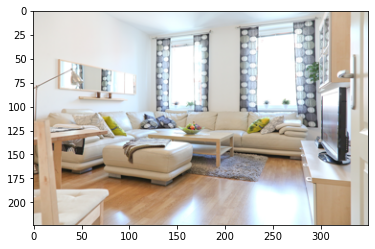

In [ ]:
IMAGE_SIZE = [350, 224]

response = requests.get(listings_meta.loc[2]["picture_url"])
img_plot = Image.open(BytesIO(response.content)).resize(IMAGE_SIZE)
plt.grid(False)
plt.imshow(img_plot)

# 5. Analyze the reviews

In [ ]:
reviews_meta.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,15883,29643839,2015-04-10,30537860,Robert,"If you need a clean, comfortable place to stay..."
1,15883,80590019,2016-06-19,37529754,Chuang,It's so nice to be in the house! It's a peace ...
2,15883,89583522,2016-07-29,3147341,Arber,"A beautiful place, uniquely decorated showing ..."
3,15883,93550424,2016-08-13,29518067,Raphaela,Eine sehr schöne Unterkunft in einem privaten ...
4,15883,114990769,2016-11-21,36016357,Chris,It was a very pleasant stay. Excellent locatio...


## Get all reviews for one entry
 The "listing_id" in the reviews file is the "id" column in the listings file

In [ ]:
senti = reviews_meta[reviews_meta["listing_id"] == listings_meta.loc[2]["id"]]
senti

,listing_id,id,date,reviewer_id,reviewer_name,comments
348,40625,73717,2010-08-04,176849,William,Ingela is a superb host. She personally welco...
349,40625,110809,2010-10-03,222519,Kerri,Ingela was a perfect host! She gave great dire...
350,40625,206046,2011-03-22,273895,Heather,Our stay in Vienna with Ingela could not have ...
351,40625,554329,2011-09-21,254998,Fernando,Our stay in the beautiful city of Vienna was g...
352,40625,584745,2011-10-01,314952,Michael,We really enjoyed our visit and loved the very...
...,...,...,...,...,...,...
505,40625,758726942,2021-05-16,219341323,Jovan,Alles Super gewesen.
506,40625,442480631302769561,2021-09-02,402971261,Richard,"Ingela is an amazing host, very friendly, help..."
507,40625,443274687839876914,2021-09-03,8795608,Anton,We have been traveling across Central Europe f...
508,40625,484538823288562944,2021-10-30,335925400,Tetiana,Many thanks for the generous hospitality! The...


## Perform sentiment analysis for these reviews

Use nlptown/bert-base-multilingual-uncased-sentiment as we have reviews in different languages

Just to give you a short idea of the reviews we will perform a simple sentiment analysis on a small subset

In [ ]:
classifier = pipeline(
    "sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment"
)

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
results = []
for i in range(100):
    temp = classifier(senti["comments"].iloc[i])
    results.append(temp)
results[0:10]

[[{'label': '5 stars', 'score': 0.6166882514953613}],
 [{'label': '5 stars', 'score': 0.9249880313873291}],
 [{'label': '4 stars', 'score': 0.3360788822174072}],
 [{'label': '5 stars', 'score': 0.7516244053840637}],
 [{'label': '5 stars', 'score': 0.5675436854362488}],
 [{'label': '5 stars', 'score': 0.6125885844230652}],
 [{'label': '5 stars', 'score': 0.5022594928741455}],
 [{'label': '5 stars', 'score': 0.8312374949455261}],
 [{'label': '5 stars', 'score': 0.49380046129226685}],
 [{'label': '4 stars', 'score': 0.6440829038619995}]]

In [ ]:
# Let#s look at one of these reviews. As most of them have *5* stars I would expect to have a highly positive review
senti["comments"].iloc[2]

"Our stay in Vienna with Ingela could not have been better!!!  She met us at the U station to personally introduce us to the fantastic apartment.  Anything and everything you could possibly need was at your fingertips, two Vienna cell phones, a small portable internet notebook, city and attraction maps-the works.  The apartment was very accessible to city transport and quick after a long day out in the city(Get the Vienna Card!!)  She even arranged our very early morning taxi to assure us the best rate!!  Vienna was amazing, our stay with Ingela just added to our experience-we can't wait to go back...."

# 6. Inspect the calendar file

In [ ]:
calendar

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,305788,2021-11-08,f,$20.00,$20.00,1.0,1125.0
1,15883,2021-11-08,f,$120.00,$120.00,1.0,365.0
2,15883,2021-11-09,t,$120.00,$120.00,1.0,365.0
3,15883,2021-11-10,t,$120.00,$120.00,1.0,365.0
4,15883,2021-11-11,t,$120.00,$120.00,1.0,365.0
...,...,...,...,...,...,...,...
4164285,53198439,2022-11-03,f,$28.00,$28.00,1.0,7.0
4164286,53198439,2022-11-04,f,$28.00,$28.00,1.0,7.0
4164287,53198439,2022-11-05,f,$28.00,$28.00,1.0,7.0
4164288,53198439,2022-11-06,f,$28.00,$28.00,1.0,7.0


# 7. Inspect the neighbourhoods.geojson file

In [ ]:
neighbours = gpd.read_file("neighbourhoods.geojson")
print(neighbours.head())

  neighbourhood  ...                                           geometry
0  Leopoldstadt  ...  MULTIPOLYGON (((16.38484 48.22616, 16.38495 48...
1    Landstra§e  ...  MULTIPOLYGON (((16.38681 48.21271, 16.38683 48...
2  Innere Stadt  ...  MULTIPOLYGON (((16.36497 48.21590, 16.36498 48...
3   Brigittenau  ...  MULTIPOLYGON (((16.38595 48.24764, 16.38611 48...
4   Floridsdorf  ...  MULTIPOLYGON (((16.37817 48.28858, 16.37819 48...

[5 rows x 3 columns]


In [ ]:
feq = listings[listings_meta["accommodates"] == 2]
feq = feq.groupby("neighbourhood")["price"].mean().sort_values(ascending=True)
feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = gpd.read_file("neighbourhoods.geojson")
adam = pd.merge(adam, feq, on="neighbourhood", how="left")
adam.rename(columns={"price": "average_price"}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)
#adam = adam.dropna()
adam = adam[adam["average_price"] < 400]

map_dict = adam.set_index("neighbourhood")["average_price"].to_dict()
color_scale = LinearColormap(
    ["yellow", "red"], vmin=min(map_dict.values()), vmax=max(map_dict.values())
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [ ]:
def get_color(feature):
    value = map_dict.get(feature["properties"]["neighbourhood"])
    return color_scale(value)


map3 = folium.Map(location=[48, 16], zoom_start=11)

In [ ]:
folium.GeoJson(
    data=adam,
    name="Berlin",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["neighbourhood", "average_price"], labels=True, sticky=False
    ),
    style_function=lambda feature: {
        "fillColor": get_color(feature),
        "color": "black",
        "weight": 1,
        "dashArray": "5, 5",
        "fillOpacity": 0.5,
    },
    highlight_function=lambda feature: {
        "weight": 3,
        "fillColor": get_color(feature),
        "fillOpacity": 0.8,
    },
).add_to(map3)
map3